In [22]:
import neuralflow # pls import the perodic_BC branch 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [23]:
print(neuralflow.__file__)

/Users/xinzheng/Desktop/Engel_rotation/TestBrainFlow/neuralflow/__init__.py


## Testing Goal:

In this notebook we plot the numerical solution of the Fokker-Plank equation (FPE) with boundary conditions and initial distribution specified, solved by our `PDESolve()` function.


</br>

$$
\begin{equation}
\frac{\partial p(x, t)}{\partial t}=\left(-D \frac{\partial}{\partial x} F(x)+D \frac{\partial}{\partial x^{2}}\right) p(x, t) \equiv-\hat{\mathcal{H_{0}}} p(x, t)
\end{equation}
$$

</br>

with the relationship of the $F(x)$ driving force (in the equation), and the two other quantities that we care about, being the potential function $\Phi(x)$, and the equilibrium probablity distribution $p_{eq}(x)$ follows:

$$
\begin{equation}
\begin{aligned}
&F(x)=-\frac{d \Phi(x)}{d x}, \quad F(x)=\frac{1}{p_{\mathrm{eq}}} \frac{d p_{\mathrm{eq}}(x)}{d x} \\
&\Phi(x)=-\log p_{\mathrm{eq}}(x) \\
&p_{\mathrm{eq}}(x)=\frac{\exp \left(\int_{-1}^{x} F\left(x^{\prime}\right) d x^{\prime}\right)}{\int_{-1}^{1} \exp \left(\int_{-1}^{x} F\left(x^{\prime}\right) d x^{\prime}\right) d x}, \quad p_{\mathrm{eq}}(x)=e^{-\Phi(x)}
\end{aligned}
\end{equation}
$$

Notice that the last term $-f(x)$ that accounted for spikes in the generalized equation form for simulation/inference is not included, as we only want to visualize the evolution of the distribution. 

The above FPE is a partial differential equation (PDE), and we have a particular solution for a PDE when the specific boundary condition (BC) and initial condition (IC) are specfified. We will be solving FPEs with different $\Phi(x)$, initial distribution $p_{0}(x)$, and our newly implemented periodic boundary along side the Dirichlet boundary to compare with, where in both cases the probability mass would be conserved over time.

### PDE Solving Strategy: 

We solve a scaled version of the differential operator $\hat{\mathcal{H_{0}}}$ to obtain a hermitian operator $\mathcal{H}$, which is unitarily diagonalizable: 

$$
\begin{equation}
\mathcal{H}=\exp (\Phi(x) / 2) \hat{\mathcal{H}} \exp (-\Phi(x) / 2)
\end{equation}
$$

that act on 

$$
\begin{equation}
\rho(x, t)=p(x, t) / \rho_{\mathrm{eq}}(x) \text {, where } \rho_{\mathrm{eq}}(x)=\exp (-\Phi(x) / 2)=\sqrt{p_{\mathrm{eq}}(x)}
\end{equation}
$$

Then we obtain the PFE form that we are going to numerically solve: 

$$
\begin{equation}
\frac{\partial \rho(x, t)}{\partial t}=-\mathcal{H} \rho(x, t)
\end{equation}
$$

and the solution takes the form:

$$
\begin{equation}
\rho\left(x_{t_{i}} \mid x_{t_{i-1}}\right)=e^{-\mathcal{H} \Delta t_{i}}
\end{equation}
$$

Therefore, essentially to find $\mathcal{H}$ at each of the time point , we are solving a eigenvalue problem:

$$
\begin{equation}
\mathcal{H} \Psi(x)=\lambda \Psi(x)
\end{equation}
$$
 

For $\mathcal{H}$ that we can formulated in to a Sturm Luiville Problem, and we use the spectral element method (SEM) to discretize space.  Eventually, we will obtain the right eigenvector matrix $Q_{0}$ for $\mathcal{H}$  and the $\hat{Q}$ from SEM. Let $Q = Q_{0}\hat{Q}$. Give both $Q_{0}$ and $\hat{Q}$ are normalized, we have $Q^{-1} = Q^{T}W$ ($W$ is the diagonal matrix of the weights of the SEM method) being the change of basis matrix from $\mathcal{H}$ to the diagnal matrix of the eigenvalues for $\mathcal{H}$, and $Q$ in turn is the matrix used to put the equation in the diagonalized descretized space. Therefore, we want to obtain the scaled initial distribution $\tilde{\rho_{0}}$  in the descretized space, and find the solution for $p(x, t)$ by:


$$
\begin{equation}
p(t) = Q \tilde{\rho_{0}} e^{\lambda t} \sqrt{p_{\mathrm{eq}}(x)}
\end{equation}
$$

where 

$$
\tilde{\rho_{0}} = Q^{T}W \rho_{0} = Q^{T}W p_{0}/ \sqrt{p_{\mathrm{eq}}(x)}
$$

</br>



## FPE with Different Potential Functions: 


In [24]:
def set_param(boundary_mode = 'circular', 
              peq_model_type = "uniform", 
              p0_mu = 200, 
              p0_min = .8):
    
    '''
    helper function to make plotting easier;
    create a parameter dictionary to specify energy models, keep the unimportant ones fixed
    '''
    
    EnergyModelParams ={'pde_solve_param':{'method':{'name': 'SEM', 'gridsize': {'Np': 8, 'Ne': 64}}}, 
               'Nv': 447,  # max eval we can have Ne* (Np -1) +1 -2 
                        
                # if we wanna change other parameters of the function
               'peq_model':{"model": peq_model_type, 'params': {}}, 
               'D0': .2,
                # xmin is xmax of prob. distribution
               'p0_model':{"model": "single_well", "params": {"miu": p0_mu, "xmin": p0_min}}, 
               'boundary_mode': boundary_mode, 
               'num_neuron':1,
               'firing_model':[{"model": "linear", "params": {"r_slope": 50, "r_bias": 60}}],
               'verbose':True
               }
    
    return EnergyModelParams

In [25]:
def solve_em(em):
    '''
    helper funciton to obtain the unscaled eval evec;
    called by solve_n_plot()
    '''
    lQ, _, Qx = em.pde_solve_.solve_EV(em.peq_, 
                                       em.D_, 
                                       q=None, 
                                       w=em.peq_, 
                                       mode='h0', # "h0" mode solve for the original solutions for SLP
                                       fr=None, 
                                       Nv=em.Nv)
    return lQ, Qx

In [45]:
def solve_n_plot(em_circ, em_refl):
    
    '''main ploting function
    '''
    lQ_circ, Qx_circ = solve_em(em_circ)
    lQ_refl, Qx_refl = solve_em(em_refl)
    
    fig, ax = plt.subplots(nrows = 2, ncols =2, figsize = [12, 10], 
                       gridspec_kw={'height_ratios': [2, 2.5]})

    # plot initial distribution
    ax[0][0].plot(em_circ.x_d_, em_circ.p0_, color = "navy", linewidth = 1.5) # pltential function

    # Hide the right and top spines
    ax[0][0].spines['right'].set_visible(False)
    ax[0][0].spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax[0][0].set_yticks(ticks = [0, 6])
    ax[0][0].set_xticks(ticks = [-1, 0, 1])
    ax[0][0].set_xlim([-1,1])
    ax[0][0].set_ylim([0,6])

    ax[0][0].xaxis.set_ticks_position('bottom')
    ax[0][0].set_ylabel("$p_{0}(x)$", fontsize = 14)
    ax[0][0].set_title("Initial Distribution", fontsize = 16)

    # plot potential function ----------------------------------------
    ax[0][1].plot(em_circ.x_d_, -np.log(em_circ.peq_), color = "black", linewidth = 2) # pltential function


    # Hide the right and top spines
    ax[0][1].spines['right'].set_visible(False)
    ax[0][1].spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax[0][1].set_yticks([])
    ax[0][1].set_xticks(ticks = [-1, 0, 1])
    ax[0][1].set_xlim([-1.1,1.05])
    ax[0][1].xaxis.set_ticks_position('bottom')
    ax[0][1].set_ylabel("$\Phi (x)$", fontsize = 14)
    ax[0][1].set_ylim([0,2])
    ax[0][1].set_title("Potential Function", fontsize = 16)

    # plot evolution over time ----------------------------------------

    time=np.linspace(0,2,30) 

    # plot circular evo: 
    rho0=Qx_circ.T.dot(np.diag(em_circ.w_d_)).dot(em_circ.p0_/np.sqrt(em_circ.peq_)) 
    ax[1][0].set_prop_cycle(plt.cycler('color', plt.cm.viridis(np.linspace(0, 1, 30))))
    for i in range(1,len(time)):
        p1 = (Qx_circ.dot(rho0.dot(np.diag(np.exp(-lQ_circ*(time[i]-time[0]))))))*np.sqrt(em_circ.peq_)
        ax[1][0].plot(em_circ.x_d_,p1, label='time={}'.format(time[i]))
    ax[1][0].set_xticks(ticks = [-1, 0, 1])
    ax[1][0].set_ylabel("$p(x,t)$" ,fontsize = 14)
    ax[1][0].set_yticks(ticks = [0, 1.5, 2.5])
    ax[1][0].set_ylim([-.5,3])

    ax[1][0].set_title("Circular Boundary" ,fontsize = 16)


    # plot reflecting evo:   
    rho0=Qx_refl.T.dot(np.diag(em_refl.w_d_)).dot(em_refl.p0_/np.sqrt(em_refl.peq_)) #Scaled p0(x) in H0 basis
    plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.cividis(np.linspace(0, 1, 30))))

    for i in range(1,len(time)):
        p1 = (Qx_refl.dot(rho0.dot(np.diag(np.exp(-lQ_refl*(time[i]-time[0]))))))*np.sqrt(em_refl.peq_)
        ax[1][1].plot(em_refl.x_d_,p1,label='time={}'.format(time[i]))
    ax[1][1].set_xticks(ticks = [-1, 0, 1])
    ax[1][1].set_yticks(ticks = [0, 1.5, 2.5])
    ax[1][1].set_ylim([-.5,3])
    ax[1][1].set_title("Reflective Boundary",fontsize = 16)
    
    fig.suptitle("Probability Distribution $p(x,t)$ over time", fontsize = 18)
    fig.tight_layout()
    fig.savefig("fig1.pdf")
    plt.show()

#### Here we can easily change to solve for different conditions:

We select to plot the case when the equilibrium solution is a sine function and a coscine square function.

In [46]:
circ_sine_param = set_param(boundary_mode = 'circular', peq_model_type = "sine_waves")
refl_sine_param = set_param(boundary_mode = 'reflecting', peq_model_type = "sine_waves")

In [47]:
em_circ_sine =neuralflow.EnergyModel(**circ_sine_param)
em_refl_sine =neuralflow.EnergyModel(**refl_sine_param)

### Solving for Sigmoidal $P_{eq}(x)$:

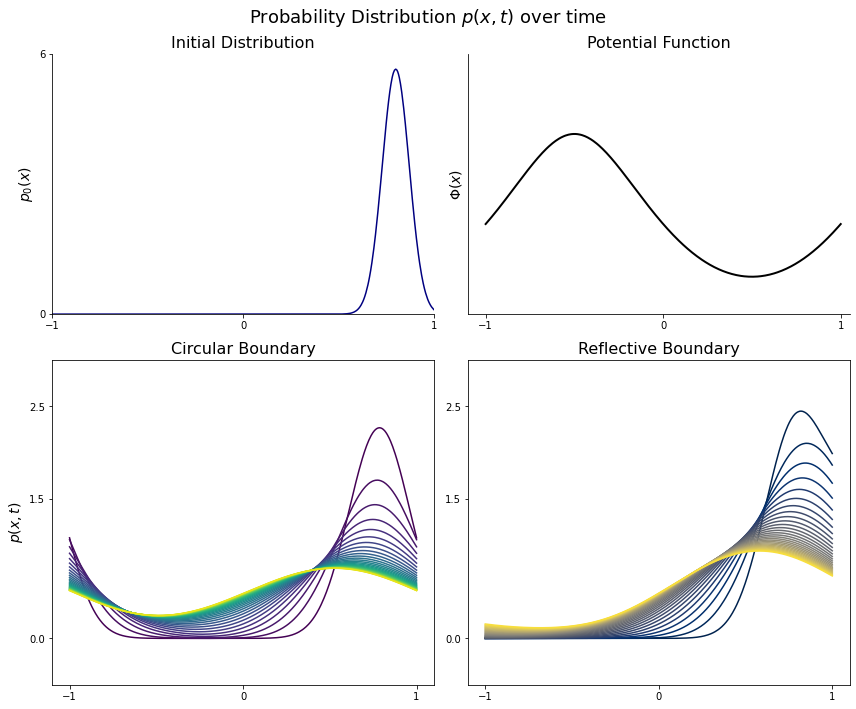

In [48]:
solve_n_plot(em_circ_sine, em_refl_sine)

In [49]:
circ_cosq_param = set_param(boundary_mode = 'circular', peq_model_type = "cos_square")
refl_cosq_param = set_param(boundary_mode = 'reflecting', peq_model_type = "cos_square")

In [50]:
em_circ_cosq =neuralflow.EnergyModel(**circ_cosq_param)
em_refl_cosq =neuralflow.EnergyModel(**refl_cosq_param)

### Solving for Cosine Square $P_{eq}(x)$:

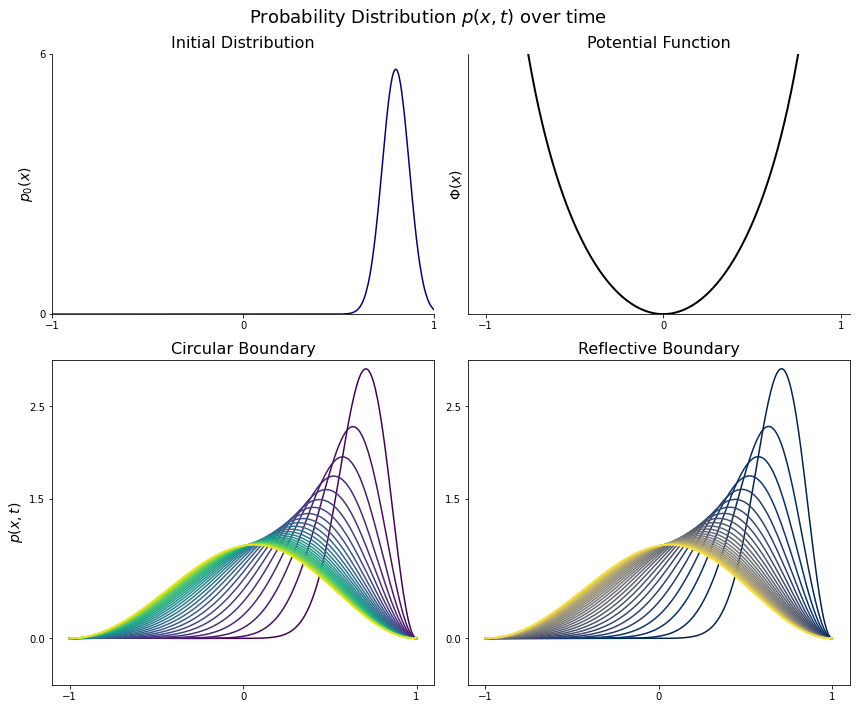

In [51]:
solve_n_plot(em_circ_cosq, em_refl_cosq)

The distribution evolution overtime looks like it behaves as expected, and our solver handles different $p_{eq}(x)$ well. Next we do a more rigorous test to show that the error of our numerical solution is extremely small.

</br>

</br>

## Comparing Numerical and Analytical Solutions

</br>

We compare our numerical solution for FPEs that admit analytical solution with finite number of terms, for which we cal plot the exact solution over time. The simplest one would be a heat equation with the initial distribution that is comibination of sinusoidal waves.

Below we outline the full solution form of the heat equation with periodic boundary with initial condition $\psi(x)$. Notice that in classic literature the IC is usually called $\phi(x)$ but we change it to avoid confusion with potential function. 


$$
\begin{equation}
\left\{\begin{array}{l}
u_{t}=k u_{x x} \\
u(x, 0)=\psi(x) \\
u(-l) = u(l); \; u_{x}(-l) = u_{x}(l)
\end{array}\right.
\end{equation}
$$

We look for equation of form:

$$
\begin{equation}
u(x, t)=X(x) T(t)
\end{equation}
$$

and therefore by the heat equation we have:

\begin{equation}
X T^{\prime}-k X^{\prime \prime} T=0
\end{equation}

So we aim to solve for $X$ and $T$:  

\begin{equation}
\frac{T^{\prime}}{k T}=\frac{X^{\prime \prime}}{X}=-\lambda \text {. }
\end{equation}


In the case of periodic boundary conditions, on the interval $[−l, l]$, the eigenvalues and eigenfunctions are given
by:

$$
\begin{equation}
\begin{aligned}
&\lambda_{n}=\left(\frac{n \pi}{l}\right)^{2}, \quad X_{n}(x)=\left\{\begin{array}{l}
\cos \left(\frac{n \pi}{l} x\right) \\
\sin \left(\frac{n \pi}{l} x\right)
\end{array} \quad n=1,2, \ldots\right. \\
&\lambda_{0}=0, \quad X_{0}(x)=C_{0} .
\end{aligned}
\end{equation}
$$

The solutions for $T_{n}$ would be given by

$$
\begin{equation}
T_{n}(t)=A_{n} e^{-k \lambda_{n} t}= \begin{cases}A_{n} e^{-k(n \pi / l)^{2} t} & n=1,2, \ldots \\ A_{0} & n=0\end{cases}
\end{equation}
$$

Therefore, we have the full solution $u_{n}(x, t) = X_{n}(x)T_{n}(t)$ with periodic BC being:

$$
\begin{equation}
u(x, t)=\sum_{n} X_{n}(x) T_{n}(t)=A_{0}+\sum_{n=1}^{\infty}\left[A_{n} \cos \left(\frac{n \pi}{l} x\right)+B_{n} \sin \left(\frac{n \pi}{l} x\right)\right] e^{-k(n \pi / l)^{2} t}
\end{equation}
$$

Our initial condition would equal:

$$
\begin{equation}
u(x, 0)=A_{0}+\sum_{n=1}^{\infty}\left[A_{n} \cos \left(\frac{n \pi}{l} x\right)+B_{n} \sin \left(\frac{n \pi}{l} x\right)\right]=\psi(x) .
\end{equation}
$$

Thus, the work left would be to find coefficients that satisfy the initial condition equation. Because periodic boundary condition is symmetric, we know that the eigenfunctions correspond to distinct eigenfalues are orthogonal. And for periodic BC particularlly,  $\cos \left(\frac{n \pi}{l} x\right)$ and $\sin \left(\frac{n \pi}{l} x\right)$ are orthogonal since:

$$
\begin{equation}
\int_{-l}^{l} \cos \left(\frac{n \pi}{l} x\right) \sin \left(\frac{n \pi}{l} x\right) d x=0
\end{equation}
$$

The fact that all eigenfunctions are orthogonal allow us to calculate the coefficient $A_{n}$, $B_{n}$ using the inner product technique:

$$
\begin{equation}
\begin{aligned}
A_{0} &=\frac{\langle 1, \psi\rangle}{\langle 1,1\rangle}=\frac{1}{2 l} \int_{-l}^{l} \psi(x) d x \\
A_{n} &=\frac{\langle\cos (n \pi x / l), \psi\rangle}{\langle\cos (n \pi x / l), \cos (n \pi x / l)\rangle}=\frac{1}{l} \int_{-l}^{l} \cos \left(\frac{n \pi}{l} x\right) \psi(x) d x \\
B_{n} &=\frac{\langle\sin (n \pi x / l), \psi\rangle}{\langle\sin (n \pi x / l), \sin (n \pi x / l)\rangle}=\frac{1}{l} \int_{-l}^{l} \sin \left(\frac{n \pi}{l} x\right) \psi(x) d x
\end{aligned}
\end{equation}
$$

In summary, the solution of a heat equation on the interval I = \[-l, l \] with periodic boundary conditions is given by

$$
\begin{equation}
u(x, t)=A_{0}+\sum_{n=1}^{\infty}\left[A_{n} \cos \left(\frac{n \pi}{l} x\right)+B_{n} \sin \left(\frac{n \pi}{l} x\right)\right] e^{-k(n \pi / l)^{2} t}
\end{equation}
$$

where:

$$
\begin{equation}
\begin{aligned}
\begin{cases}
A_{0} &=\frac{1}{2 l} \int_{-l}^{l} \psi(x) d x \\
A_{n} &=\frac{1}{l} \int_{-l}^{l} \cos \left(\frac{n \pi}{l} x\right) \psi(x) d x \\
B_{n} &=\frac{1}{l} \int_{-l}^{l} \sin \left(\frac{n \pi}{l} x\right) \psi(x) d x .
\end{cases}
\end{aligned}
\end{equation}
$$

</br>

When $l = 1$, and if we very conveniently set our initial condition $\psi(x) = \sin \left( \pi x \right) +  \frac{1}{2} \sin \left( 2\pi x \right) $ (just one example of finite combination of sigmoidal functions), then due to the orthogonality properties, then all coefficient higher than 2 will all be zero, and we can plot the exact solution for $u(x, t)$ with only two non zero coefficient left:


$$B_{1} = 1 \quad B_{2} = 1$$

and the full solution becomes:

$$
\begin{equation}
u(x, t)=  \sin \left( \pi x \right)   e^{- k \pi ^{2} t} + \frac{1}{2}  \sin \left( 2 \pi x \right)   e^{- 4 k \pi ^{2} t}
\end{equation}
$$

which makes sense since the sines should decay independently. 

To normalize the euqation to a valid probability distribution, we scale $u(x,t)$ down and add a constant, then we obtain:

$$
\begin{equation}
p(x, t)=  \frac{1}{3} \sin \left( \pi x \right)   e^{- k \pi ^{2} t} + \frac{1}{6}  \sin \left( 2 \pi x \right)   e^{- 4 k \pi ^{2} t} + \frac{1}{2}
\end{equation}
$$

Diffusion coefficient $k$ correspond to the noise magnitude parameter $D_{0}$. Therefore, we can set up the initial distribution, boundary condition and the FPE form to match the heat equation problem for our `PDE_Solve()` module to solve numerically. We'll plot the exact solution and numierical solution of $p(x, t)$ and the errors. 

### Plotting the Numerical Solution:

In [12]:
D = .1

EnergyModelParams ={'pde_solve_param':{'method':{'name': 'SEM', 'gridsize': {'Np': 8, 'Ne': 64}}}, 
               'Nv': 447,  # max eval we can have Ne* (Np -1) +1 -2 
               'peq_model':{"model": "uniform", 'params': {}},
               'D0': D,
               'p0_model':{"model": "sine_family", 'params': {}},
               'boundary_mode': "circular", 
               'num_neuron':1,
               'firing_model':[{"model": "linear", "params": {"r_slope": 50, "r_bias": 60}}],
               'verbose':True
               }

em_circ = neuralflow.EnergyModel(**EnergyModelParams)
lQ_circ, Qx_circ = solve_em(em_circ)

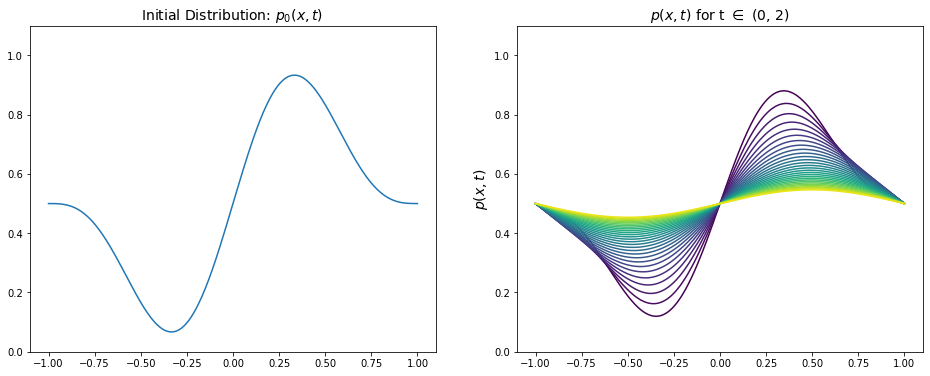

In [14]:
fig, ax = plt.subplots(ncols = 2, figsize = [16,6])

ax[0].plot(em_circ.x_d_, em_circ.p0_)
ax[0].set_ylim([0, 1.1])
ax[0].set_title("Initial Distribution: $p_{0}(x, t)$ ", fontsize = 14)

time=np.linspace(0,2,30) 

rho0=Qx_circ.T.dot(np.diag(em_circ.w_d_)).dot(em_circ.p0_/np.sqrt(em_circ.peq_)) 

p1_numer = np.ndarray(shape =(30, len(em_circ.x_d_)))

ax[1].set_prop_cycle(plt.cycler('color', plt.cm.viridis(np.linspace(0, 1, 30))))
for i in range(1,len(time)):
    p1_numer[i,:] = np.transpose((Qx_circ.dot(rho0.dot(np.diag(np.exp(-lQ_circ*(time[i]-time[0]))))))*np.sqrt(em_circ.peq_))
    ax[1].plot(em_circ.x_d_,p1_numer[i,:], label='time={}'.format(time[i]))

# time = 1
# p1 = (Qx_circ.dot(rho0.dot(np.diag(np.exp(-lQ_circ*time)))))*np.sqrt(em_circ.peq_)
# ax[1].plot(em_circ.x_d_,p1)
    
#ax.set_xticks(ticks = [-1, 0, 1])
ax[1].set_ylabel("$p(x,t)$" ,fontsize = 14)
ax[1].set_ylim([0, 1.1])
ax[1].set_title("$p(x, t)$ for t $\in$ (0, 2)", fontsize = 14)
plt.show()

### Plotting the Exact Solution :

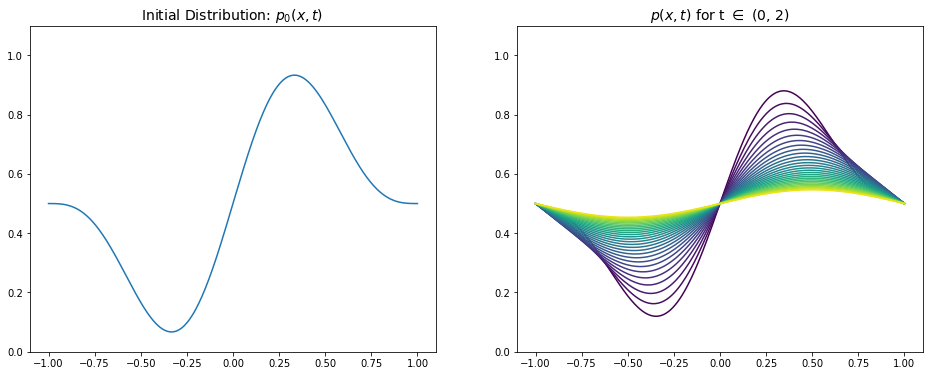

In [15]:
fig, ax = plt.subplots(ncols = 2, figsize = [16,6])

x = em_circ.x_d_

p0 = 1/3*np.sin(np.pi*x) + 1/6*np.sin(2*np.pi*x) + 1/2

t =np.linspace(0,2,30) 

p1_exact = np.ndarray(shape =(30, len(x)))

k = .1

ax[0].plot(x, p0)
ax[0].set_ylim([0, 1.1])
ax[0].set_title("Initial Distribution: $p_{0}(x, t)$ ", fontsize = 14)

# plot circular evo: 
ax[1].set_prop_cycle(plt.cycler('color', plt.cm.viridis(np.linspace(0, 1, 30))))

for i in range(1,len(t)):
    p1_exact[i,:] = np.transpose(1/3*np.sin(np.pi*x)*np.exp(-k*np.pi**2*t[i]) + 1/6*np.sin(2*np.pi*x)*np.exp(-4*k*np.pi**2*t[i]) + 1/2) 
    ax[1].plot(x,p1_exact[i,:], label='time={}'.format(t[i]))
ax[1].set_ylim([0, 1.1])
ax[1].set_title("$p(x, t)$ for t $\in$ (0, 2)", fontsize = 14)
plt.show()

### Error Calculation:

First, we calculate the difference in initial condition to confirm we evolve from the same starting point; then we calculate the solution over 30 different $t \in (0, 2) and tabulate the mean and standard deviation of the errors. 

The errors of our numerical solutions are very small: 

In [16]:
p0_diff = p0 - em_circ.p0_

In [17]:
print('The mean error for initial distribution is %.3e.' % np.mean(p0_diff))

The mean error for initial distribution is -1.122e-16.


In [18]:
ave_diff = [np.mean(p1_exact[n,:]- p1_numer[n,:]) for n in range(1,30)]
std_diff = [np.std(p1_exact[n,:]- p1_numer[n,:]) for n in range(1,30)]
diff_df = pd.DataFrame(np.transpose(np.array([ave_diff, std_diff])), index = list(range(1,30)), columns = ["mean error", "standard deviation"])

#### Plotting the error for each time point:

In [19]:
diff_df

,mean error,standard deviation
1,-1.985811e-13,1.391618e-12
2,-3.972734e-13,2.143181e-12
3,-5.988804e-13,2.674085e-12
4,-8.033121e-13,3.098562e-12
5,-1.010460e-12,3.461857e-12
6,-1.220221e-12,3.784727e-12
7,-1.432411e-12,4.077899e-12
8,-1.646493e-12,4.347481e-12
9,-1.862414e-12,4.597285e-12
10,-2.079914e-12,4.829864e-12
